# Классификация музыкальных произведений по жанрам для стриммингового сервиса "МиФаСоль". 

#### О проекте. ####

Популярный музыкальный стримминговый сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Сотрудники отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

#### Цель. ####

- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам
- оценить качество алгоритма по метрике F1


#### План. ####

- загрузка и ознакомление с данными
- предварительная обработка
- полноценный разведочный анализ
- разработка новых синтетических признаков
- проверка на мультиколлинеарность
- отбор финального набора обучающих признако,
- выбор и обучение моделей
- итоговая оценка качества предсказания лучшей модели
- анализ важности ее признаков
- подготовка отчета по исследованию

### Шаг 1. Загрузка и ознакомление с данными 

In [2]:
import pandas as pd
import math
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform, loguniform
import lightgbm as lgb


import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import roc_curve 
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
import numpy as np
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
train_data = pd.read_csv("/kaggle/input/workshop-project-first/kaggle_music_genre_train.csv")
test_data = pd.read_csv("/kaggle/input/workshop-project-first/kaggle_music_genre_test.csv")

In [5]:
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [6]:
train_data.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000


In [7]:
test_data.info()
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121


In [8]:
test_data.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5099.000000,5099.000000,5099.000000,5.099000e+03,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,4978.000000,5099.000000
mean,55643.871347,0.276324,0.561888,2.173974e+05,0.622030,0.165198,0.197924,-8.630186,0.092718,121.246463,0.465593
std,20762.384803,0.322657,0.170502,1.156374e+05,0.251829,0.311940,0.166241,5.619766,0.100130,29.875950,0.244217
min,20012.000000,0.000002,0.059600,-1.000000e+00,0.001540,0.000000,0.020400,-46.122000,0.022600,37.114000,0.020500
25%,37571.000000,0.016600,0.451000,1.737335e+05,0.465000,0.000000,0.096950,-10.231000,0.035700,96.070250,0.272000
50%,55246.000000,0.120000,0.568000,2.175000e+05,0.660000,0.000157,0.129000,-7.135000,0.048700,120.053500,0.458000
75%,73702.000000,0.460000,0.681000,2.642470e+05,0.826000,0.092750,0.248000,-5.127000,0.096550,141.934250,0.650000
max,91709.000000,0.996000,0.977000,1.360027e+06,0.999000,0.994000,0.990000,1.949000,0.918000,216.029000,0.982000


#### 1.1 Вывод ####

Данные выгружены, но они довольно таки грязные, предстоит обработка.

### Шаг 2. Предварительная обработка

#### Шаг 2.1 Корреляция

Такие колонки как `instance_id`, `track_name` и `obtained_date` не будут влиять на результат, т.к. не содержат полезной информации. Поэтому можем от них избавиться.

In [9]:
train_data = train_data.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

Теперь посмотрим дубликаты. При их наличии дропаем.

In [10]:
print(train_data.duplicated().sum())
train_data = train_data.drop_duplicates()

7


Теперь рассмотрим корреляцию с помощью `phik`

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


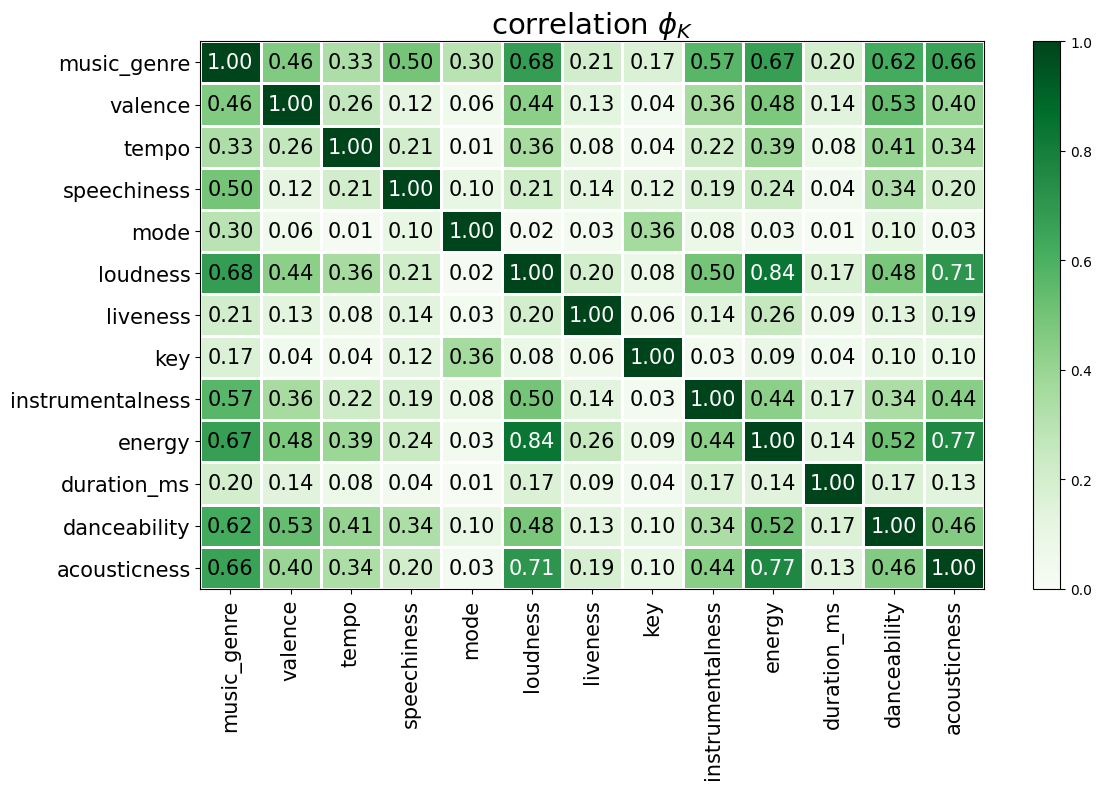

In [11]:
phik_overview = train_data.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(12, 8))
plt.tight_layout()

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


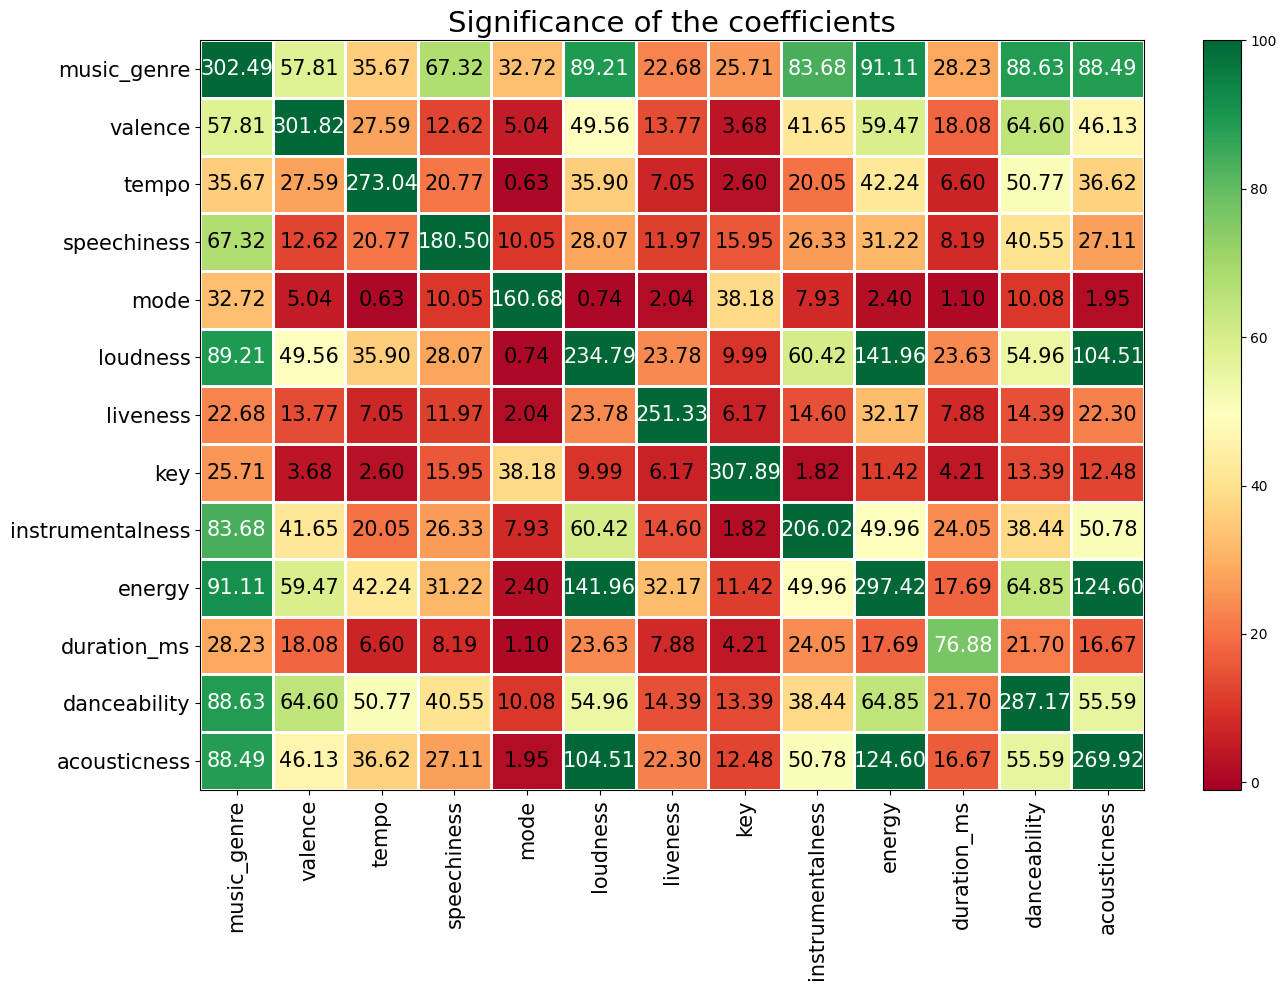

In [12]:
significance_overview = train_data.significance_matrix()
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-1, vmax=100, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(14, 10))
plt.tight_layout()

Заметна большая корреляция между:

- `music_genre` – `loudness`
- `music_genre` – `instrumentalness`
- `music_genre` – `energy`
- `music_genre` – `dancebility`
- `music_genre` –`acousticness`
- `loudness` – `acousticness`
- `loudness` – `energy`
- `energy` – `acousticness`



Рассмотрим **Глобальную корелляцию**, она даст нам представление о том, насколько хорошо одну переменную можно смоделировать с использованием других переменных.

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


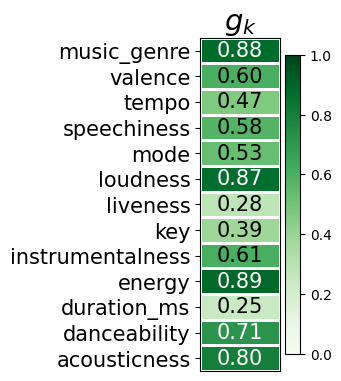

In [13]:
global_correlation, global_labels = train_data.global_phik()

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

Заметна большая корреляция у loudness, energy и acousticness

Посмотрим пропуски в датасете.

In [14]:
train_data.isna().sum()


acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 734
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
valence               0
music_genre           0
dtype: int64

Пропуски содержат столбцы:
- `key`
- `mode`
- `tempo`

Их мы обработаем с помощью **`Pipeline и ColumnTransformer`**

#### Шаг 2.2 **`Pipeline и ColumnTransformer`**

In [15]:
X = train_data.drop(['music_genre'], axis = 1)
y = train_data['music_genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
cat_columns = X.select_dtypes(include='category').columns.tolist()
num_columns = X.select_dtypes(include='number').columns.tolist()

In [16]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')), 
    ('scale', MinMaxScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), 
    ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [17]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_columns),
    ('cat_pipeline', cat_pipeline, cat_columns)
    ],remainder='drop',
    n_jobs =-1)

**num_pipeline (числовые данные) состоит из:**

1. SimpleImputer для заполнения пропущенного значения средним значением этого столбца.
2. MinMaxScaler для масштабирования значения в диапазоне от 0 до 1 (это повлияет на производительность регрессии).

**cat_pipeline (категориальные данные) состоит из:**
 
1. SimpleImputer, чтобы заполнить отсутствующее значение наиболее часто встречающимся значением этого столбца.
2. OneHotEncoder для обработки множества числовых столбцов для обучения модели. (указан handle_unknown='ignore', чтобы предотвратить ошибку при обнаружении невидимой категории в тестовом наборе)

#### 2.3 Подбор гиперпараметров, с помощью RandomizedSearchCV ####

In [18]:
# r_model = RandomForestClassifier(random_state=12345)
# r_model_pipeline = Pipeline(steps=[('col_trans', col_trans),
#                                    ('model', r_model)])

# param_dist = {
#     'model__n_estimators': [100, 200, 300],
#     'model__max_depth': [None, 5, 10],
# }

# grid = RandomizedSearchCV(r_model_pipeline,
#                     param_dist,
#                     n_iter=30,
#                     cv=5,
#                     verbose=5,
#                     random_state=12345,
#                     scoring='f1_micro',
#                     n_jobs=-1)

In [19]:
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# predicted = grid.predict(X_test)
# f1_score(y_test, predicted, average='micro')

**Лучший показатель модели RandomForestClassifier**
- Best Parameters: {'model__n_estimators': 200, 'model__max_depth': 10}
- Best F1 Micro Score: 0.47


In [20]:
# lr_model = LogisticRegression()

# lr_pipeline = Pipeline(steps=[
#     ('col_trans', col_trans),
#     ('model', lr_model)
# ])

# param_dist = {
#     'model__penalty': ['l1', 'l2', 'elasticnet'],  # тип регуляризации
#     'model__C': uniform(0, 30),  # обратная сила регуляризации
#     'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # метод оптимизации
#     'model__C': loguniform(1e-4, 1e4),  # обратная сила регуляризации в логарифмической шкале
#     'model__max_iter': [100, 200, 300, 400, 500],  # максимальное количество итераций оптимизационного алгоритма
#     'model__multi_class': ['auto', 'ovr', 'multinomial']  # стратегия многоклассовой классификации
# }

# grid = RandomizedSearchCV(
#     lr_pipeline,
#     param_dist,
#     n_iter=30,  # Количество случайных комбинаций гиперпараметров
#     verbose=5,
#     cv=5,  # Количество фолдов в кросс-валидации
#     scoring='f1_micro',  # Используем метрику F1_micro
#     n_jobs=-1  # Используем все доступные ядра процессора
# )


In [21]:
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# predicted = grid.predict(X_test)
# f1_score(y_test, predicted, average='micro')


**Лучший показатель модели LogisticRegression**
- Best Parameters: {'model__C': 18.175613103122156, 'model__max_iter': 300, 'model__multi_class': 'auto', 'model__penalty': 'l1', 'model__solver': 'saga'}
- Best F1 Micro Score: 0.39

In [22]:
# Создаем модель LightGBM
lgb_model = lgb.LGBMClassifier()


lgb_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', lgb_model)
])


# Задаем пространство поиска гиперпараметров
param_dist = {
    'model__boosting_type': ['gbdt', 'dart', 'goss'],  # Тип бустинга
    'model__num_leaves': randint(20, 200),  # Максимальное количество листьев в дереве
    'model__learning_rate': uniform(0.01, 0.3),  # Скорость обучения
    'model__n_estimators': randint(50, 200),  # Количество деревьев
    'model__subsample_for_bin': randint(20000, 300000),  # Размер выборки для построения гистограммы
    'model__min_child_samples': randint(20, 500),  # Минимальное количество образцов в листе
    'model__reg_alpha': uniform(0, 1),  # L1 регуляризация
    'model__reg_lambda': uniform(0, 1),  # L2 регуляризация
    'model__colsample_bytree': uniform(0.6, 1.0)  # Доля признаков при построении каждого дерева
}



# Создаем объект RandomizedSearchCV
grid = RandomizedSearchCV(
    lgb_pipeline,
    param_dist,
    n_iter=30,  # Количество случайных комбинаций гиперпараметров
    cv=5,  # Количество фолдов в кросс-валидации
    scoring='f1_micro',  # Используем метрику F1_micro
    n_jobs=-1  # Используем все доступные ядра процессора
)

In [23]:
grid.fit(X_train, y_train)
print(grid.best_params_)
predicted = grid.predict(X_test)
f1_score(y_test, predicted, average='micro')


[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 373 .

[LightGBM] [Fatal] Check failed: (feature_fraction) <= (1.0) at /__w/1/s/pyt

{'model__boosting_type': 'dart', 'model__colsample_bytree': 0.9038471172196185, 'model__learning_rate': 0.08190267181058641, 'model__min_child_samples': 402, 'model__n_estimators': 98, 'model__num_leaves': 178, 'model__reg_alpha': 0.6132250384496662, 'model__reg_lambda': 0.29668761264803367, 'model__subsample_for_bin': 20522}


0.47229033840117707

**Лучший показатель модели LightGBM**
- Best Parameters: {'model__boosting_type': 'gbdt', 'model__colsample_bytree': 0.8295189628085221, 'model__learning_rate': 0.032830863526326394, 'model__min_child_samples': 361, 'model__n_estimators': 193, 'model__num_leaves': 163, 'model__reg_alpha': 0.903475273748531, 'model__reg_lambda': 0.9052009831378935, 'model__subsample_for_bin': 67058}

- Best F1 Micro Score: 0.474

#### Шаг 2.4 Вывод.

#### 1. Обработка данных. ####

**num_pipeline (числовые данные) состоит из:**

1. SimpleImputer для заполнения пропущенного значения средним значением этого столбца.
2. MinMaxScaler для масштабирования значения в диапазоне от 0 до 1 (это повлияет на производительность регрессии).

**cat_pipeline (категориальные данные) состоит из:**
 
1. SimpleImputer, чтобы заполнить отсутствующее значение наиболее часто встречающимся значением этого столбца.
2. OneHotEncoder для обработки множества числовых столбцов для обучения модели. (указан handle_unknown='ignore', чтобы предотвратить ошибку при обнаружении невидимой категории в тестовом наборе)


#### 2. Подбор гиперпараметров. ####

- **Лучший показатель модели RandomForestClassifier**
    - Best Parameters: {'model__n_estimators': 200, 'model__max_depth': 10}
    - Best F1 Micro Score: 0.47


- **Лучший показатель модели LogisticRegression**
    - Best Parameters: {'model__C': 18.175613103122156, 'model__max_iter': 300, 'model__multi_class': 'auto', 'model__penalty': 'l1', 'model__solver': 'saga'}
    - Best F1 Micro Score: 0.39
    
    
- **Лучший показатель модели LightGBM**
    - Best Parameters: {'model__boosting_type': 'gbdt', 'model__colsample_bytree': 0.8295189628085221, 'model__learning_rate': 0.032830863526326394, 'model__min_child_samples': 361, 'model__n_estimators': 193, 'model__num_leaves': 163, 'model__reg_alpha': 0.903475273748531, 'model__reg_lambda': 0.9052009831378935, 'model__subsample_for_bin': 67058}

    - Best F1 Micro Score: 0.474    
    
    
    
    
***Таким образом мы заполнили пропуски и получили гиперпараметры для модели. Теперь можем переходить к финальномк тестированию
P.s код закоментирован, чтобы при перезапуске тетрадки не ждать сбора параметров, для проверки код можно раскомментить ^_^***    

In [24]:
# rfc = RandomForestClassifier(n_estimators=200, max_depth=10)

# rfc_pipeline = Pipeline(steps=[
#     ('pipeline', col_trans),
#     ('model', rfc)
# ])

# rfc_pipeline.fit(X_train, y_train)
# y_pred = rfc_pipeline.predict(X_test)

# print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))


In [25]:
# lr = LogisticRegression(solver='saga', penalty='l1', C=18.175613103122156
#                        , multi_class='auto', max_iter=300)
# lr_pipeline = Pipeline(steps=[
#     ('col_trans', col_trans),
#     ('model', lr)
# ])

# lr_pipeline.fit(X_train, y_train)
# y_pred = lr_pipeline.predict(X_test)

# print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))


In [26]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8295189628085221, 
                              learning_rate=0.032830863526326394, min_child_samples=361,
                              n_estimators=193, num_leaves=163,
                              reg_alpha=0.903475273748531, reg_lambda=0.9052009831378935,
                              subsample_for_bin=67058)


lgb_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', lgb_model)
])

lgb_pipeline.fit(X_train, y_train)
y_pred = lgb_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(3))


f1_micro = 0.473


### 3. Тестирование модели на тестовых данных. ###

In [27]:
test_copy = test_data.copy()
test_data = test_data.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [28]:
features_train = train_data.drop('music_genre', axis=1)
target_train = train_data['music_genre']

In [29]:
lgb_pipeline.fit(features_train, target_train)
y_pred = lgb_pipeline.predict(test_data)

y_pred = y_pred.ravel().tolist()


y_pred_series = pd.Series(y_pred, name='music_genre')

instance_id_column = test_copy['instance_id']

submit = pd.concat([instance_id_column, y_pred_series], axis=1)

submit.to_csv('lgb_pipeline.csv', index=False)


***Загрузка файла показала результат:***

**f1_score -** `0.46684`

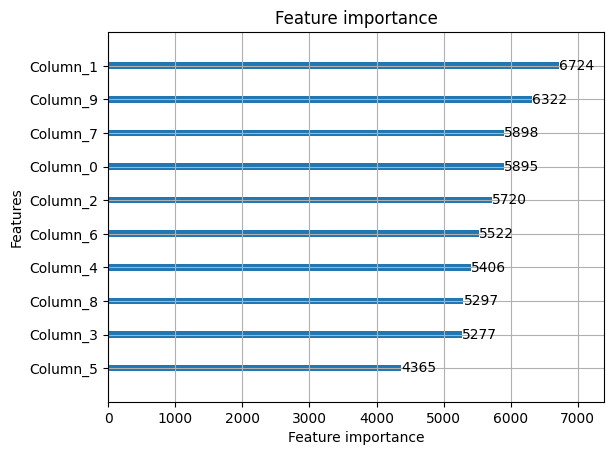

In [54]:
lgb_pipeline.fit(X_train, y_train)

# Визуализируем важность признаков
lgb.plot_importance(lgb_pipeline.named_steps['model'], max_num_features=10,
                    importance_type='split')
plt.show()


**Колонки:** `danceability, speechiness, loudness`
Являются наиболее важные признаки для модели.

### Вывод

#### 1. Обработка данных. ####

**num_pipeline (числовые данные) состоит из:**

1. SimpleImputer для заполнения пропущенного значения средним значением этого столбца.
2. MinMaxScaler для масштабирования значения в диапазоне от 0 до 1 (это повлияет на производительность регрессии).

**cat_pipeline (категориальные данные) состоит из:**
 
1. SimpleImputer, чтобы заполнить отсутствующее значение наиболее часто встречающимся значением этого столбца.
2. OneHotEncoder для обработки множества числовых столбцов для обучения модели. (указан handle_unknown='ignore', чтобы предотвратить ошибку при обнаружении невидимой категории в тестовом наборе)


#### 2. Подбор гиперпараметров. ####

- **Лучший показатель модели RandomForestClassifier**
    - Best Parameters: {'model__n_estimators': 200, 'model__max_depth': 10}
    - Best F1 Micro Score: 0.47


- **Лучший показатель модели LogisticRegression**
    - Best Parameters: {'model__C': 18.175613103122156, 'model__max_iter': 300, 'model__multi_class': 'auto', 'model__penalty': 'l1', 'model__solver': 'saga'}
    - Best F1 Micro Score: 0.39
    
    
- **Лучший показатель модели LightGBM**
    - Best Parameters: {'model__boosting_type': 'gbdt', 'model__colsample_bytree': 0.8295189628085221, 'model__learning_rate': 0.032830863526326394, 'model__min_child_samples': 361, 'model__n_estimators': 193, 'model__num_leaves': 163, 'model__reg_alpha': 0.903475273748531, 'model__reg_lambda': 0.9052009831378935, 'model__subsample_for_bin': 67058}

    - Best F1 Micro Score: 0.474    
    
    
#### 3. Тестирование модели на тестовых данных и наиболее важные признаки. ####
- ***Загрузка файла показала результат:***
    **f1_score -** `0.46684`

- **Колонки:** `danceability, speechiness, loudness`
    **Являются наиболее важные признаки для модели.**


#### 4. Рекомендации ###
- Решить проблемы с качеством данных и минимизировать появления пропусков, дублей, выбросов.
- Акцентировать внимание на данные из стобиков: `danceability, speechiness, loudness`.
- Изменить признаки в связи их мультиколлинеарности.
